In [ ]:
%pip install gurobipy
%pip install gurobipy_pandas
%pip install gurobi-machinelearning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 2.6 MB/s eta 0:00:00


In [ ]:

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np

random_state = 1234 # get reproducible trees

In [ ]:
from gurobi_ml import add_predictor_constr
import gurobipy as gp
import gurobipy_pandas as gppd

In [ ]:
DOE_url = "https://github.com/Raziye-Aghapour/RET_GreenBuilding/raw/main/RET%20-%20Cost%20Output.xlsx"
Cost = pd.read_excel(DOE_url, engine='openpyxl')

Variables_level_url = "https://raw.githubusercontent.com/Raziye-Aghapour/RET_GreenBuilding/main/RET%20-Variables_level.csv"
Factors_levels = pd.read_csv(Variables_level_url)


In [ ]:
Cost

,RoofExtFinish,RoofExteriorInsulation,RoofAddlInsulation,AGWExtFinish,AGWExteriorInsulation,AGWInteriorInsulation,AGWAddlInsulation,CeilingsBattInsulation,VerticalWallsBattInsulation,GlassCategory,GlassTypeThickness,GlassTypeSpacing,GlassTypeEmissivity,FrameType,System1HeatingSource,System1SystemType,SupplyFans,HeaterFuel,HeaterType,kWhyear
0,Light,0,0,Light,10.5,4,13,0,19,Double Low E,0.125,0.250,High,FiberglassFixedMlt spacer,Electric Resistance,Split System Single Zone,Variable,Gas,Storage,4994.6
1,Dark,0,19,Light,10.5,4,13,0,19,Triple Low E,0.250,0.500,High,WoofFixedMltSpacer,Electric Resistance,Packaged VVT,Two-Speed,Electricity,instantaneous,5757.7
2,Dark,4,19,Dark,21.0,4,13,0,21,Triple Low E,0.250,0.500,High,FiberglassFixedMlt spacer,DX Coils,Split System Single Zone,Variable,Gas,Storage,3502.0
3,Light,4,0,Light,10.5,0,19,0,19,Triple Low E,0.250,0.500,High,FiberglassFixedMlt spacer,DX Coils,Packaged VVT,Variable,Electricity,Storage,4575.0
4,Dark,4,19,Light,10.5,0,19,0,19,Double Low E,0.125,0.250,High,WoofFixedMltSpacer,DX Coils,Split System Single Zone,Two-Speed,Gas,instantaneous,3874.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Aluminum Paint,8,49,Uncolored,10.5,0,11,26,11,Quadruple Low E,0.125,0.333,Low,AlumwBrkFixedMtlSpacer,DX Coils,Split System Single Zone,Forward Curved Centrifugal w/ Inlet Vanes,Electricity,Storage,3982.8
76,Aluminum Paint,30,60,Uncolored,12.0,4,13,49,11,Quadruple Low E,0.125,0.333,Low,AlumwBrkFixedMtlSpacer,DX Coils,Split System Single Zone,Forward Curved Centrifugal w/ Inlet Vanes,Electricity,Storage,3874.5
77,Aluminum Paint,14,3,Medium,8.0,0,11,30,19,Quadruple Low E,0.125,0.333,Low,ReinforcedVinylFixedMtlSpacer,DX Coils,Split System Single Zone,Forward Curved Centrifugal w/ Inlet Vanes,Electricity,Storage,3984.4
78,Uncolored,20,15,Uncolored,4.0,0,7,7,0,Quadruple Low E,0.125,0.333,Low,ReinforcedVinylFixedMtlSpacer,DX Coils,Split System Single Zone,Forward Curved Centrifugal w/ Inlet Vanes,Electricity,Storage,4445.9


In [ ]:
# classify our features between the ones that are fixed and the ones that will be
# part of the optimization problem
features = Cost.columns.tolist()[:-1]
target = Cost.columns.tolist()[-1]

Cat_features=Factors_levels[Factors_levels['type'] == 'Categorical']['description'].tolist()

Num_features=Factors_levels[Factors_levels['type'] == 'Numerical-Continuous']['description'].tolist()


print(features)
print(len(Cat_features))

['RoofExtFinish', 'RoofExteriorInsulation', 'RoofAddlInsulation', 'AGWExtFinish', 'AGWExteriorInsulation', 'AGWInteriorInsulation', 'AGWAddlInsulation', 'CeilingsBattInsulation', 'VerticalWallsBattInsulation', 'GlassCategory', 'GlassTypeThickness', 'GlassTypeSpacing', 'GlassTypeEmissivity', 'FrameType', 'System1HeatingSource', 'System1SystemType', 'SupplyFans', 'HeaterFuel', 'HeaterType']
10


In [ ]:
# # Encode categorical variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Initialize the ColumnTransformer with OneHotEncoder for the categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False), Cat_features)
    ],
    remainder='passthrough'  # Keep the remaining numerical columns
)

# Apply the transformations
transformed_data = column_transformer.fit_transform(Cost)

# Get the names of the new one-hot encoded columns
new_columns = column_transformer.get_feature_names_out()

# Create a new DataFrame with the transformed data and new column names
encoded_Cost = pd.DataFrame(transformed_data, columns=new_columns)

encoded_features = encoded_Cost.columns.tolist()[:-1]
encoded_target = encoded_Cost.columns.tolist()[-1]


encoded_Cost.head()




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,cat__RoofExtFinish_Aluminum Paint,cat__RoofExtFinish_Dark,cat__RoofExtFinish_Light,cat__RoofExtFinish_Uncolored,cat__AGWExtFinish_Dark,cat__AGWExtFinish_Light,cat__AGWExtFinish_Medium,cat__AGWExtFinish_Uncolored,cat__GlassCategory_Double Low E,cat__GlassCategory_Quadruple Low E,...,remainder__RoofExteriorInsulation,remainder__RoofAddlInsulation,remainder__AGWExteriorInsulation,remainder__AGWInteriorInsulation,remainder__AGWAddlInsulation,remainder__CeilingsBattInsulation,remainder__VerticalWallsBattInsulation,remainder__GlassTypeThickness,remainder__GlassTypeSpacing,remainder__kWhyear
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,10.5,4.0,13.0,0.0,19.0,0.125,0.25,4994.6
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,19.0,10.5,4.0,13.0,0.0,19.0,0.250,0.50,5757.7
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,19.0,21.0,4.0,13.0,0.0,21.0,0.250,0.50,3502.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.0,0.0,10.5,0.0,19.0,0.0,19.0,0.250,0.50,4575.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,4.0,19.0,10.5,0.0,19.0,0.0,19.0,0.125,0.25,3874.0


In [ ]:
##Grouping the categorical features


from collections import defaultdict

# Initialize a defaultdict to hold lists of one-hot encoded variables for each original category
one_hot_to_original_mapping = defaultdict(list)

# Assuming 'encoded_features' is a list of your one-hot encoded feature names
# and 'Cat_features' is a list of your original categorical feature names
for feature_name in encoded_features:
    for cat_var in Cat_features:
        if cat_var in feature_name:
            one_hot_to_original_mapping[cat_var].append(feature_name)
            break  # Assuming each one-hot encoded feature can only belong to one category

# Now, one_hot_to_original_mapping maps from original categories to lists of one-hot encoded feature names
print(one_hot_to_original_mapping)

defaultdict(<class 'list'>, {'RoofExtFinish': ['cat__RoofExtFinish_Aluminum Paint', 'cat__RoofExtFinish_Dark', 'cat__RoofExtFinish_Light', 'cat__RoofExtFinish_Uncolored'], 'AGWExtFinish': ['cat__AGWExtFinish_Dark', 'cat__AGWExtFinish_Light', 'cat__AGWExtFinish_Medium', 'cat__AGWExtFinish_Uncolored'], 'GlassCategory': ['cat__GlassCategory_Double Low E', 'cat__GlassCategory_Quadruple Low E', 'cat__GlassCategory_Single Low E', 'cat__GlassCategory_Triple Low E'], 'GlassTypeEmissivity': ['cat__GlassTypeEmissivity_High', 'cat__GlassTypeEmissivity_Low'], 'FrameType': ['cat__FrameType_AlumwBrkFixedMtlSpacer', 'cat__FrameType_FiberglassFixedMlt spacer', 'cat__FrameType_ReinforcedVinylFixedMtlSpacer', 'cat__FrameType_WoofFixedMltSpacer'], 'System1HeatingSource': ['cat__System1HeatingSource_DX Coils', 'cat__System1HeatingSource_Electric Resistance'], 'System1SystemType': ['cat__System1SystemType_Packaged VVT', 'cat__System1SystemType_Split System Single Zone'], 'SupplyFans': ['cat__SupplyFans_For

In [ ]:
from sklearn.model_selection import train_test_split

X = encoded_Cost[encoded_features]
y = encoded_Cost[encoded_target]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)



There are two main hyperparameters that you need to tune to prevent a boosted regression ensemble from overfitting the training set:

* `learning_rate`: this hyperparameter weights the contribution of each tree. Low values like 0.1 imply more trees are needed in the ensemble, but will typically lead to better generalisation error.
* `n_estimators`: this hyperparameter controls the number of trees in the ensemble. Adding too many trees can lead to overfitting.

In [ ]:

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.metrics import r2_score


common_params = dict(
    n_estimators=13,
    max_depth=3,
)

gbr = GradientBoostingRegressor(loss="squared_error" , **common_params)


gbr_tree = make_pipeline(

    gbr
)

gbr_tree.fit(X_train, y_train)


mse = mean_squared_error(y_test, gbr_tree.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


# Get R^2 from test data

print(f"The R^2 value in the test set is {r2_score(y_test, gbr_tree.predict(X_test))}")

gbr_tree.fit(X, y)

print(f"The R^2 value in the full dataset is {np.round(r2_score(y, gbr_tree.predict(X)),5)}")

The mean squared error (MSE) on test set: 39977.5152
The R^2 value in the test set is 0.8891290698146248
The R^2 value in the full dataset is 0.83528


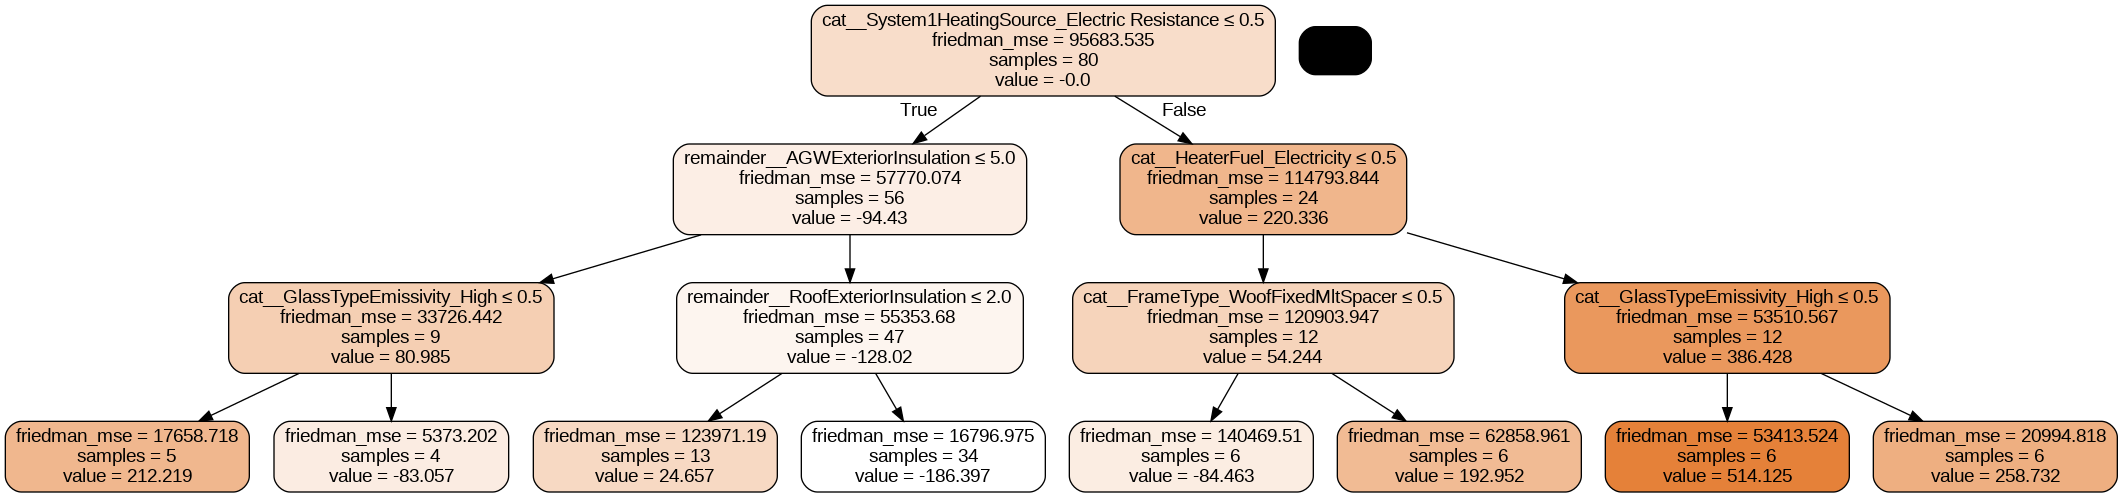

In [ ]:


from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

decision_tree_estimator = gbr_tree.steps[-1][1]

# Export and visualize the decision tree
dot_data = export_graphviz(
    decision_tree_estimator.estimators_[-1, 0],
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    feature_names=encoded_features  # Pass the one-hot encoded feature names
)

# Create a GraphViz graph from dot data
graph = graph_from_dot_data(dot_data)

# Convert the graph to PNG image
png = graph.create_png()

# Save (optional)
from pathlib import Path
Path('./out.png').write_bytes(png)

# Display
Image(png)

In [ ]:
m = gp.Model("Green_budling_GB")

Restricted license - for non-production use only - expires 2025-11-24


In [ ]:
# Add binary variables for the one-hot encoded columns
binary_columns = [col for col in encoded_Cost.columns if col.startswith('cat__')]
for column in binary_columns:
    m.addVar(vtype=gp.GRB.BINARY, name=column)

# Add continuous variables for the original numerical variables
# We use the prefix 'remainder__' to identify the original numerical columns
continuous_columns = [col for col in encoded_Cost[encoded_features] if col.startswith('remainder__')]
for column in continuous_columns:
    # Extract the original column name (without 'remainder__' prefix)
    original_column_name = column.replace('remainder__', '')
    # Define bounds based on the min and max values of the original column
    lb = Cost[original_column_name].min()
    ub = Cost[original_column_name].max()
    # Add the variable to the model with the defined bounds
    m.addVar(lb=lb, ub=ub, vtype=gp.GRB.CONTINUOUS, name=column)

# Update the model to integrate the new variables
m.update()

# Now, your model has the necessary decision variables defined as per your dataset.

In [ ]:
Cost_approx = m.addVar(name="Cost_approx")
m.update

<bound method Model.update of <gurobi.Model MIP instance Green_budling_GB: 0 constrs, 38 vars, No parameter changes>>

In [ ]:
m.setObjective(Cost_approx, gp.GRB.MINIMIZE)


In [ ]:
# Assuming m is your Gurobi model
variables_dict = {var.VarName: var for var in m.getVars()}
# Create a DataFrame with a single row containing the Gurobi variables
variables_df = pd.DataFrame(variables_dict, index=[0])

In [ ]:
variables_df[encoded_features]

,cat__RoofExtFinish_Aluminum Paint,cat__RoofExtFinish_Dark,cat__RoofExtFinish_Light,cat__RoofExtFinish_Uncolored,cat__AGWExtFinish_Dark,cat__AGWExtFinish_Light,cat__AGWExtFinish_Medium,cat__AGWExtFinish_Uncolored,cat__GlassCategory_Double Low E,cat__GlassCategory_Quadruple Low E,...,cat__HeaterType_instantaneous,remainder__RoofExteriorInsulation,remainder__RoofAddlInsulation,remainder__AGWExteriorInsulation,remainder__AGWInteriorInsulation,remainder__AGWAddlInsulation,remainder__CeilingsBattInsulation,remainder__VerticalWallsBattInsulation,remainder__GlassTypeThickness,remainder__GlassTypeSpacing
0,<gurobi.Var cat__RoofExtFinish_Aluminum Paint>,<gurobi.Var cat__RoofExtFinish_Dark>,<gurobi.Var cat__RoofExtFinish_Light>,<gurobi.Var cat__RoofExtFinish_Uncolored>,<gurobi.Var cat__AGWExtFinish_Dark>,<gurobi.Var cat__AGWExtFinish_Light>,<gurobi.Var cat__AGWExtFinish_Medium>,<gurobi.Var cat__AGWExtFinish_Uncolored>,<gurobi.Var cat__GlassCategory_Double Low E>,<gurobi.Var cat__GlassCategory_Quadruple Low E>,...,<gurobi.Var cat__HeaterType_instantaneous>,<gurobi.Var remainder__RoofExteriorInsulation>,<gurobi.Var remainder__RoofAddlInsulation>,<gurobi.Var remainder__AGWExteriorInsulation>,<gurobi.Var remainder__AGWInteriorInsulation>,<gurobi.Var remainder__AGWAddlInsulation>,<gurobi.Var remainder__CeilingsBattInsulation>,<gurobi.Var remainder__VerticalWallsBattInsula...,<gurobi.Var remainder__GlassTypeThickness>,<gurobi.Var remainder__GlassTypeSpacing>


In [ ]:
from gurobi_ml import add_predictor_constr

# Assuming gbr_model is your trained gradient boosting model
# And assuming feats is a list of feature names used by your model, which should match the column names in variables_df

# Use add_predictor_constr to add your model to the optimization problem
pred_constr = add_predictor_constr(m, gbr_tree, variables_df[encoded_features], Cost_approx)

# Update the model to integrate the new constraints
m.update()

pred_constr.print_stats()

Model for pipe:
117 variables
14 constraints
416 general constraints
Input has shape (1, 38)
Output has shape (1, 1)

Pipeline has 1 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
gbtree_reg            (1, 1)          117           14            0          416

--------------------------------------------------------------------------------


In [ ]:
# Assuming 'm' is your Gurobi model
for cat_var, one_hot_vars in one_hot_to_original_mapping.items():
    # Sum the binary variables corresponding to the one-hot encoded categories of each original feature
    # Ensure that this sum is >= 1, meaning at least one category must be selected
    m.addConstr(gp.quicksum(m.getVarByName(var) for var in one_hot_vars) >= 1, name=f"select_at_least_one_{cat_var}")

# Update the model to integrate the new constraints
m.update()

In [ ]:
m.write('boosted_tree_opt.lp')
m.display()

Minimize
  Cost_approx
Subject To
pipe.gbtree_reg.tree.R0: pipe.gbtree_reg.tree.leafs[0,0] +
pipe.gbtree_reg.tree.leafs[0,1] + pipe.gbtree_reg.tree.leafs[0,2] +
pipe.gbtree_reg.tree.leafs[0,3] + pipe.gbtree_reg.tree.leafs[0,4] +
pipe.gbtree_reg.tree.leafs[0,5] + pipe.gbtree_reg.tree.leafs[0,6] +
 pipe.gbtree_reg.tree.leafs[0,7] = 1
pipe.gbtree_reg.tree0.R1: pipe.gbtree_reg.tree0.leafs[0,0] +
pipe.gbtree_reg.tree0.leafs[0,1] + pipe.gbtree_reg.tree0.leafs[0,2] +
pipe.gbtree_reg.tree0.leafs[0,3] + pipe.gbtree_reg.tree0.leafs[0,4] +
pipe.gbtree_reg.tree0.leafs[0,5] + pipe.gbtree_reg.tree0.leafs[0,6] +
 pipe.gbtree_reg.tree0.leafs[0,7] = 1
pipe.gbtree_reg.tree1.R2: pipe.gbtree_reg.tree1.leafs[0,0] +
pipe.gbtree_reg.tree1.leafs[0,1] + pipe.gbtree_reg.tree1.leafs[0,2] +
pipe.gbtree_reg.tree1.leafs[0,3] + pipe.gbtree_reg.tree1.leafs[0,4] +
pipe.gbtree_reg.tree1.leafs[0,5] + pipe.gbtree_reg.tree1.leafs[0,6] +
 pipe.gbtree_reg.tree1.leafs[0,7] = 1
pipe.gbtree_reg.tree2.R3: pipe.gbtree_reg.tree2.

<ipython-input-20-a62e0587ef62>:2: DeprecationWarning: Model.display() is deprecated
  m.display()


'pipe.gbtree_reg.tree6.leafs[0,0]', 'pipe.gbtree_reg.tree6.leafs[0,1]',
'pipe.gbtree_reg.tree6.leafs[0,2]', 'pipe.gbtree_reg.tree6.leafs[0,3]',
'pipe.gbtree_reg.tree6.leafs[0,4]', 'pipe.gbtree_reg.tree6.leafs[0,5]',
'pipe.gbtree_reg.tree6.leafs[0,6]', 'pipe.gbtree_reg.tree6.leafs[0,7]',
'pipe.gbtree_reg.tree7.leafs[0,0]', 'pipe.gbtree_reg.tree7.leafs[0,1]',
'pipe.gbtree_reg.tree7.leafs[0,2]', 'pipe.gbtree_reg.tree7.leafs[0,3]',
'pipe.gbtree_reg.tree7.leafs[0,4]', 'pipe.gbtree_reg.tree7.leafs[0,5]',
'pipe.gbtree_reg.tree7.leafs[0,6]', 'pipe.gbtree_reg.tree7.leafs[0,7]',
'pipe.gbtree_reg.tree8.leafs[0,0]', 'pipe.gbtree_reg.tree8.leafs[0,1]',
'pipe.gbtree_reg.tree8.leafs[0,2]', 'pipe.gbtree_reg.tree8.leafs[0,3]',
'pipe.gbtree_reg.tree8.leafs[0,4]', 'pipe.gbtree_reg.tree8.leafs[0,5]',
'pipe.gbtree_reg.tree8.leafs[0,6]', 'pipe.gbtree_reg.tree8.leafs[0,7]',
'pipe.gbtree_reg.tree9.leafs[0,0]', 'pipe.gbtree_reg.tree9.leafs[0,1]',
'pipe.gbtree_reg.tree9.leafs[0,2]', 'pipe.gbtree_reg.tree9.leafs

In [ ]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 24 rows, 156 columns and 147 nonzeros
Model fingerprint: 0x770cff5e
Model has 416 general constraints
Variable types: 23 continuous, 133 integer (133 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 6e+01]
  RHS range        [1e+00, 4e+03]
  GenCon rhs range [4e-01, 2e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve added 190 rows and 52 columns
Presolve time: 0.07s
Presolved: 214 rows, 208 columns, 654 nonzeros
Presolved model has 104 SOS constraint(s)
Variable types: 105 continuous, 103 integer (103 binary)
Found heuristic solution: objective 5637.7745608
Found heuristic solution: objective 3970.9917718

Root relaxation: 

In [ ]:
# Variable info
varInfo = [(v.varName, v.X, v.LB, v.UB) for v in m.getVars() ]
df = pd.DataFrame(varInfo)
df.columns=['Variable Name','Solution Value', 'LB','UB']
df.to_excel("variables.xlsx", index=False)
df_var = df.query('`Solution Value` > 0')
df.to_csv('out.csv')
df_var

,Variable Name,Solution Value,LB,UB
0,cat__RoofExtFinish_Aluminum Paint,1.000000,0.000,1.00
1,cat__RoofExtFinish_Dark,1.000000,0.000,1.00
2,cat__RoofExtFinish_Light,1.000000,0.000,1.00
3,cat__RoofExtFinish_Uncolored,1.000000,0.000,1.00
4,cat__AGWExtFinish_Dark,1.000000,0.000,1.00
5,cat__AGWExtFinish_Light,1.000000,0.000,1.00
6,cat__AGWExtFinish_Medium,1.000000,0.000,1.00
7,cat__AGWExtFinish_Uncolored,1.000000,0.000,1.00
8,cat__GlassCategory_Double Low E,1.000000,0.000,1.00
9,cat__GlassCategory_Quadruple Low E,1.000000,0.000,1.00


In [ ]:
m.dispose()